In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, RobustScaler, MinMaxScaler
from sklearn.cluster import KMeans
import wrangle_zillow as w
import explore as e
import scipy.stats as stats

In [2]:
df = w.get_zillow_data()

In [3]:
df= w.single_unit_properties(df)

In [4]:
df=w.handle_missing_values(df, prop_required_column = .60, prop_required_row = .60)

In [5]:
train, validate, test =w.impute_missing_values(df)

In [6]:
train, validate, test = w.impute_missing_values_1(train, validate, test)

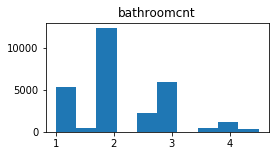

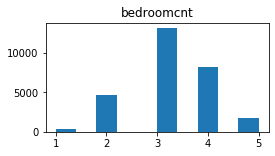

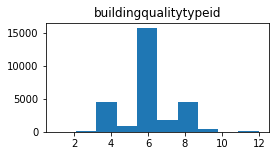

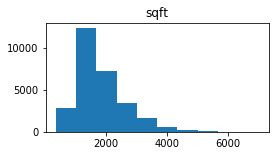

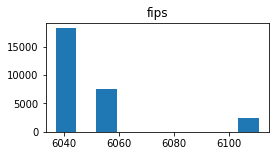

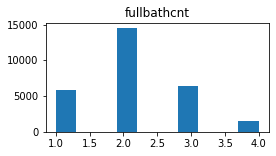

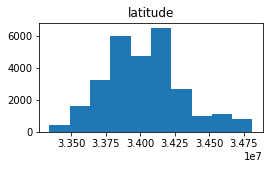

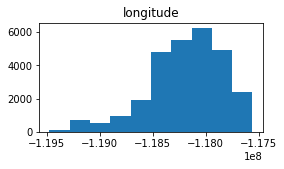

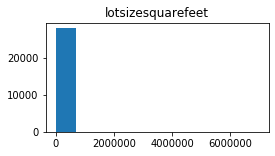

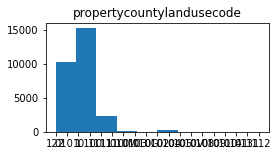

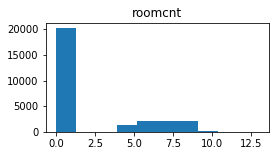

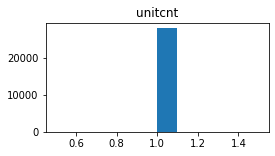

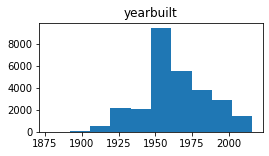

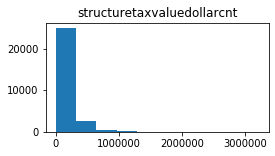

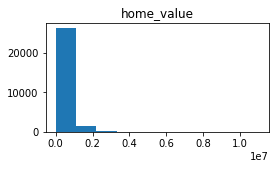

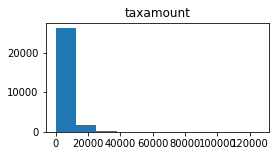

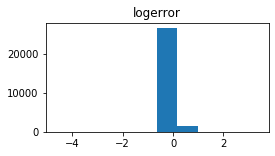

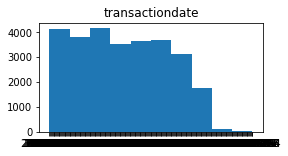

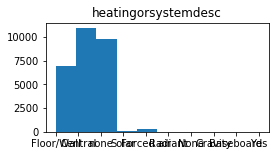

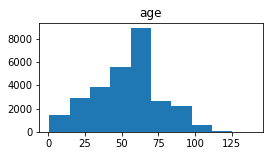

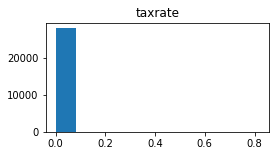

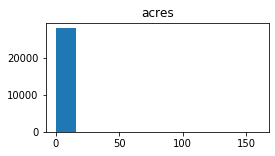

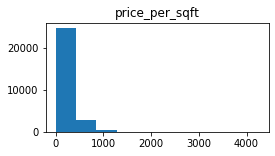

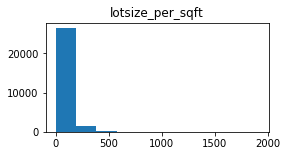

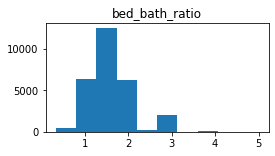

In [7]:
 for col in train.columns:
    plt.figure(figsize=(4,2))
    plt.hist(train[col])
    plt.title(col)
    plt.show()

## Features normally distributed
    - bedroomcnt
    - building quality type id
    - fullbathcnt
    - latitude
    - year built
    - age
    - bed bath ratio
    
## Features skewed right
    - sqft
    
## Features skewed left
    - longitude
    

## Is there a relationship between price_per_sqft and logerror?

In [8]:
train.head().T

,1616,33322,44530,32756,67546
bathroomcnt,1,3,4.5,3,3
bedroomcnt,2,4,5,4,2
buildingqualitytypeid,6,7,6,6,7
sqft,906,2548,4733,2776,2083
fips,6059,6037,6059,6059,6037
fullbathcnt,1,3,4,3,3
latitude,3.38536e+07,3.44671e+07,3.35811e+07,3.37002e+07,3.40441e+07
longitude,-1.18013e+08,-1.18203e+08,-1.17691e+08,-1.17726e+08,-1.1839e+08
lotsizesquarefeet,4536,107586,29600,6933,6379
propertycountylandusecode,122,0101,122,1,0100


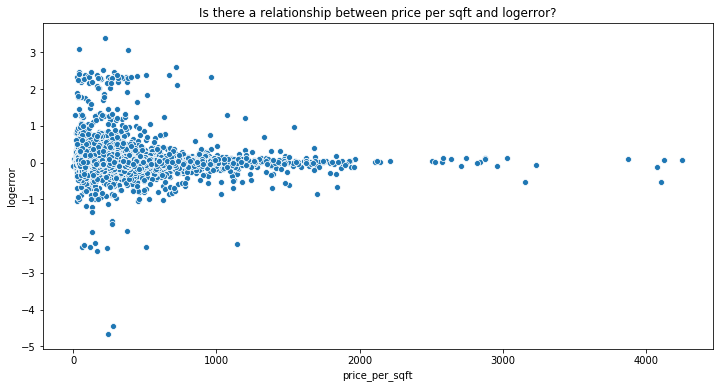

In [9]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=train, x='price_per_sqft', y='logerror')
plt.title('Is there a relationship between price per sqft and logerror?')
plt.show()

- Going to bin price_per_sqft

In [11]:
train['binned_price_per_sqft'] = pd.cut(train.price_per_sqft, [0,1000,2000,5000] , labels=["small", "medium", "large"])

In [22]:
train.binned_price_per_sqft.value_counts(dropna=False)

small     27845
medium      264
large        24
Name: binned_price_per_sqft, dtype: int64

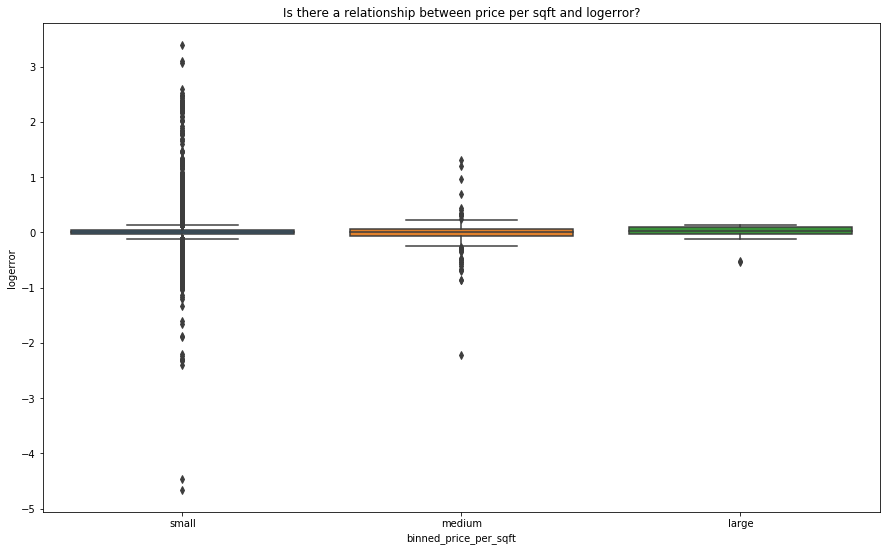

In [23]:
plt.figure(figsize=(15,9))
sns.boxplot(x= 'binned_price_per_sqft', y = 'logerror', data = train)
plt.title('Is there a relationship between price per sqft and logerror?')
plt.show()

## Hard to see if there is a correlation here. Going to run a statistical test (ANOVA) to see if there is a significance in the means of price per sqft and log error.

In [27]:
small_price_per_sqft_ratio = train[train.binned_price_per_sqft == 'small'].price_per_sqft
medium_price_per_sqft_ratio = train[train.binned_price_per_sqft == 'medium'].price_per_sqft
large_price_per_sqft_ratio = train[train.binned_price_per_sqft == 'large'].price_per_sqft

- Ho: Means of binned price_per_sqft_ratio small, medium, large are equal
- Ha: Means of binned price_per_sqft_ratio, medium, large are not equal
- alpha = .05

In [24]:
print(small_price_per_sqft_ratio.var())
print(medium_price_per_sqft_ratio.var())
print(large_price_per_sqft_ratio.var())

25797.376400826815
66359.22062652641
441774.5297190322


In [28]:
f, p = stats.f_oneway(small_price_per_sqft_ratio, medium_price_per_sqft_ratio, large_price_per_sqft_ratio)
f, p

(8553.03763805571, 0.0)

- We reject the null Hypothesis. p-value is less than alpha. The means of binned price per sqft ratio are not equal.

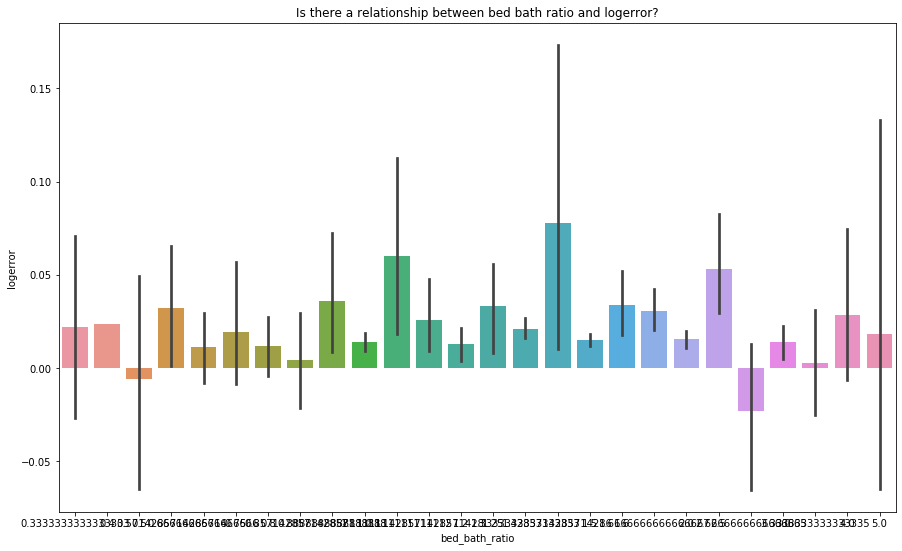

In [15]:
plt.figure(figsize=(15,9))
sns.barplot(x= 'bed_bath_ratio', y = 'logerror', data = train)
plt.title('Is there a relationship between bed bath ratio and logerror?')
plt.show()

In [16]:
train['binned_bed_bath_ratio'] = pd.qcut(train.bed_bath_ratio, 3, labels=["small", "medium", "large"])

In [17]:
train.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,sqft,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,...,transactiondate,heatingorsystemdesc,age,taxrate,acres,price_per_sqft,lotsize_per_sqft,bed_bath_ratio,binned_price_per_sqft,binned_bed_bath_ratio
1616,1.0,2.0,6.0,906.0,6059.0,1.0,33853594.0,-118013182.0,4536.0,122,...,2017-01-09,Floor/Wall,57.0,0.011973,0.104132,309.910596,61.900132,2.000000,small,large
33322,3.0,4.0,7.0,2548.0,6037.0,3.0,34467094.0,-118202886.0,107586.0,0101,...,2017-05-05,Central,35.0,0.011922,2.469835,166.306122,3.938691,1.333333,small,small
44530,4.5,5.0,6.0,4733.0,6059.0,4.0,33581133.0,-117690741.0,29600.0,122,...,2017-06-08,none,10.0,0.010278,0.679522,432.012043,69.078142,1.111111,small,small
32756,3.0,4.0,6.0,2776.0,6059.0,3.0,33700191.0,-117725630.0,6933.0,1,...,2017-05-04,none,3.0,0.016351,0.159160,392.491354,157.155056,1.333333,small,small
67546,3.0,2.0,7.0,2083.0,6037.0,3.0,34044109.0,-118390335.0,6379.0,0100,...,2017-08-17,Central,70.0,0.012270,0.146442,364.217955,118.931807,0.666667,small,small


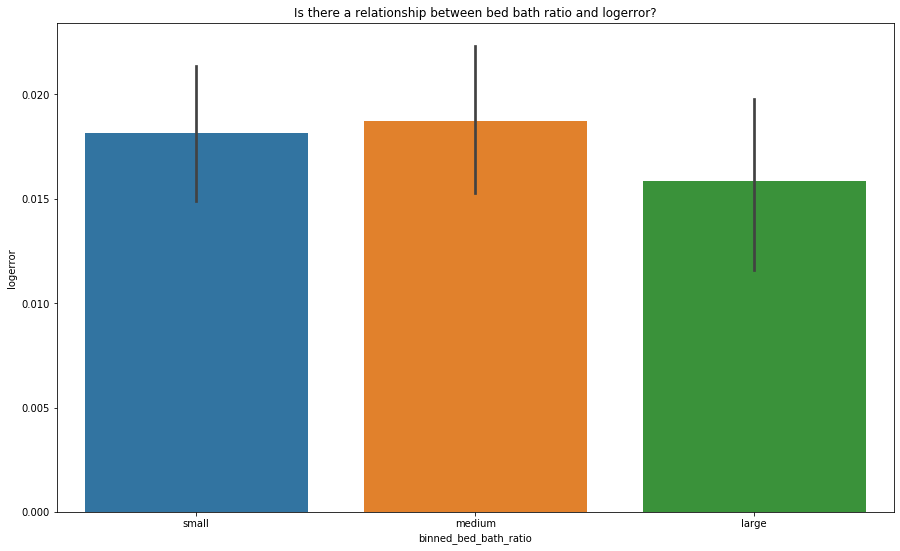

In [18]:
plt.figure(figsize=(15,9))
sns.barplot(x= 'binned_bed_bath_ratio', y = 'logerror', data = train)
plt.title('Is there a relationship between bed bath ratio and logerror?')
plt.show()

## Going to run a Annova Test to see if there is a significance in bed_bath_ratio to logerror

In [19]:
small_bed_bath_ratio = train[train.binned_bed_bath_ratio == 'small'].bed_bath_ratio
medium_bed_bath_ratio = train[train.binned_bed_bath_ratio == 'medium'].bed_bath_ratio
large_bed_bath_ratio = train[train.binned_bed_bath_ratio == 'large'].bed_bath_ratio

 - Ho: Means of binned bed_bath_ratio small, medium, large are equal
 - Ha: Means of binned bed_bath_ratio small, medium, large are not equal
 - alpha = .05

In [20]:
print(small_bed_bath_ratio.var())
print(medium_bed_bath_ratio.var())
print(large_bed_bath_ratio.var())

0.033051008814788396
0.0029452921387648568
0.24418842500563911


In [21]:
f, p = stats.f_oneway(small_bed_bath_ratio, medium_bed_bath_ratio, large_bed_bath_ratio)
f, p

(36437.66493599394, 0.0)

- We reject the null Hypothesis. p-value is less than alpha.  The means of binned bed bath ratio are not equal.

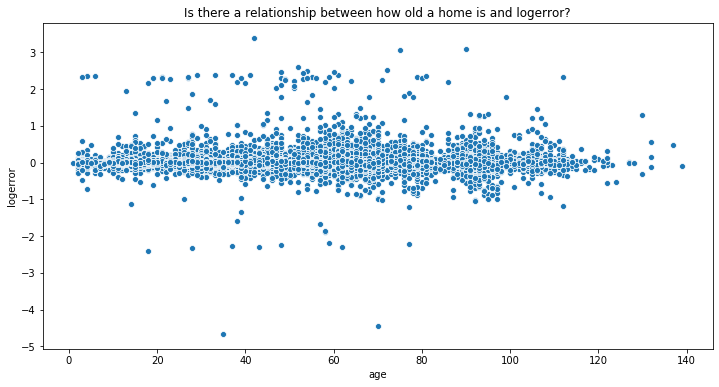

In [29]:
plt.figure(figsize = (12,6))
sns.scatterplot(data=train, x='age', y='logerror')
plt.title('Is there a relationship between how old a home is and logerror?')
plt.show()


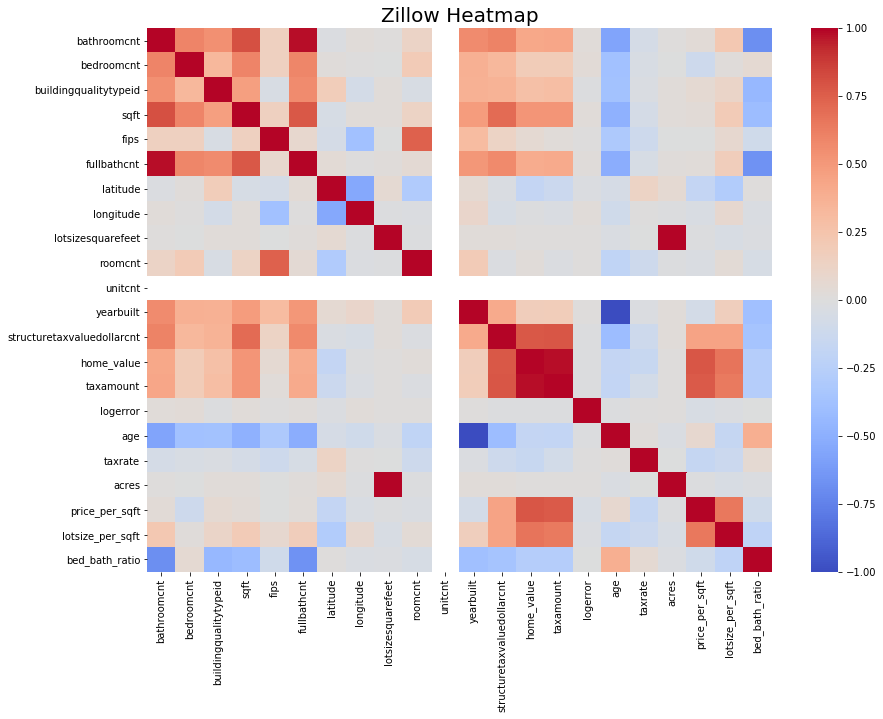

In [31]:
# Heat map showing how the variables correlate to each other
plt.figure(figsize=(14,10))
sns.heatmap(train.corr(),
            vmin = -1, 
            cmap='coolwarm',
           annot=False).set_title("Zillow Heatmap", fontsize=20);

- Looking at the bottom 3 variables. They seem to have a correlation. Age, bathroomcnt, bedroomcnt, sqft, fullbath,yearbuilt, structure tax value count and building quality type id looks like they have some correlation

In [32]:
train.corr()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,sqft,fips,fullbathcnt,latitude,longitude,lotsizesquarefeet,roomcnt,...,structuretaxvaluedollarcnt,home_value,taxamount,logerror,age,taxrate,acres,price_per_sqft,lotsize_per_sqft,bed_bath_ratio
bathroomcnt,1.000000,0.599332,0.543201,0.807946,0.154347,0.978971,-0.016331,0.029158,0.015594,0.119313,...,0.604623,0.425775,0.431182,0.023609,-0.562665,-0.064004,0.015594,0.035496,0.225420,-0.682809
bedroomcnt,0.599332,1.000000,0.329855,0.599616,0.154581,0.589462,0.018889,0.007504,-0.002383,0.196376,...,0.335254,0.190629,0.195118,0.031455,-0.380906,-0.040952,-0.002383,-0.113319,0.018396,0.061149
buildingqualitytypeid,0.543201,0.329855,1.000000,0.473765,-0.043583,0.565473,0.184546,-0.073117,0.030377,-0.046097,...,0.364279,0.277152,0.294188,-0.012662,-0.369413,-0.030227,0.030377,0.059915,0.110288,-0.444048
sqft,0.807946,0.599616,0.473765,1.000000,0.151637,0.777631,-0.046927,0.025888,0.029640,0.127964,...,0.710090,0.515796,0.518985,0.028839,-0.486019,-0.069366,0.029640,0.032310,0.202058,-0.410590
fips,0.154347,0.154581,-0.043583,0.151637,1.000000,0.081357,-0.065461,-0.381245,-0.007154,0.743087,...,0.125464,0.061153,0.025024,0.004583,-0.305765,-0.109609,-0.007154,-0.005193,0.070395,-0.097681
fullbathcnt,0.978971,0.589462,0.565473,0.777631,0.081357,1.000000,0.042867,0.000112,0.018100,0.053024,...,0.575977,0.403224,0.413329,0.020780,-0.510227,-0.049774,0.018100,0.028547,0.179162,-0.668172
latitude,-0.016331,0.018889,0.184546,-0.046927,-0.065461,0.042867,1.000000,-0.540240,0.055444,-0.289952,...,-0.030112,-0.176548,-0.130714,-0.021793,-0.056661,0.125231,0.055444,-0.174146,-0.285584,0.015361
longitude,0.029158,0.007504,-0.073117,0.025888,-0.381245,0.000112,-0.540240,1.000000,-0.013733,-0.020430,...,-0.053417,-0.013329,-0.024640,0.030431,-0.100845,0.005559,-0.013733,-0.038402,0.077910,-0.024365
lotsizesquarefeet,0.015594,-0.002383,0.030377,0.029640,-0.007154,0.018100,0.055444,-0.013733,1.000000,-0.011789,...,0.024579,0.008877,0.008118,0.012430,-0.030105,-0.002196,1.000000,-0.008904,-0.039122,-0.021688
roomcnt,0.119313,0.196376,-0.046097,0.127964,0.743087,0.053024,-0.289952,-0.020430,-0.011789,1.000000,...,-0.022069,0.024164,-0.023083,0.015011,-0.198811,-0.111146,-0.011789,-0.026727,0.043539,-0.052657


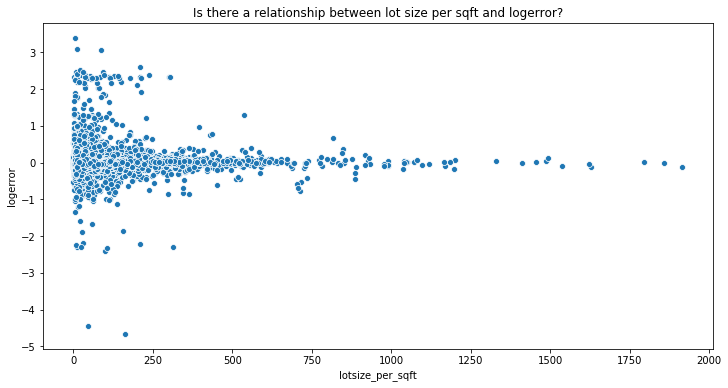

In [33]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=train, x='lotsize_per_sqft', y='logerror')
plt.title('Is there a relationship between lot size per sqft and logerror?')
plt.show()

- There appears to be a lot of error on the differnt lot sized up to 300 or so before leveling off.